In [36]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

# Baixar recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')

# Carregar dataset
df = pd.read_excel("FakeRecogna.xlsx")

# Exibir informações básicas do dataset
print("Formato do dataset:", df.shape)
print(df.columns)
print(df['Classe'].value_counts())

[nltk_data] Downloading package stopwords to /home/iara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/iara/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/iara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Formato do dataset: (11903, 8)
Index(['Titulo', 'Subtitulo', 'Noticia', 'Categoria', 'Data', 'Autor', 'URL',
       'Classe'],
      dtype='object')
Classe
0.0    5951
1.0    5951
Name: count, dtype: int64


Representações em vetores

- Técnica: TF-IDF (Term Frequency - Inverse Document Frequency)

1- Conversão de texto para números → Modelos de ML não processam texto bruto.

2- Destaca palavras importantes → Reduz peso de palavras comuns e enfatiza termos relevantes.

3- Melhora a precisão → Melhor que Bag of Words ao diferenciar Fake News de notícias verdadeiras.

4- Evita alta dimensionalidade → Limitamos para 5000 palavras mais frequentes (max_features=5000).

5- Funciona bem com modelos tradicionais → Compatível com Reg. Logística e Random Forest.

6- Alternativa eficiente → Simples, leve e mais rápido que Word2Vec ou BERT.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Verificar e tratar valores ausentes na coluna 'Classe'
print("Valores ausentes em 'Classe':", df['Classe'].isna().sum())
df = df.dropna(subset=['Classe'])  # Remover linhas com valores NaN
df['Classe'] = df['Classe'].astype(int)  # Converter para inteiro

# Função para limpeza de texto
def limpar_texto(texto):
    if not isinstance(texto, str):  # Verificar se o valor é uma string válida
        return ""
    
    texto = re.sub(r'http\S+|www\S+', '', texto) 
    texto = re.sub(r'[^a-zA-Z\s]', '', texto) 
    tokens = word_tokenize(texto.lower()) 
    
    stop_words = set(stopwords.words('portuguese'))  
    tokens = [word for word in tokens if word not in stop_words] 
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens] 
    
    return ' '.join(tokens) 

# Preencher valores nulos em 'Noticia' com string vazia antes do processamento
df['Noticia'] = df['Noticia'].fillna('')
df['Noticia'] = df['Noticia'].astype(str).apply(limpar_texto)

# Separar dados em treino e teste 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=45, stratify=df['Classe'])

vectorizer = TfidfVectorizer(max_features=5000)  # Limite de 5000 palavras mais relevantes
X_train_tfidf = vectorizer.fit_transform(train_df['Noticia'])
X_test_tfidf = vectorizer.transform(test_df['Noticia'])

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, train_df['Classe'])

train_df_smote = pd.DataFrame(X_train_smote.toarray(), columns=vectorizer.get_feature_names_out())
train_df_smote['Classe'] = y_train_smote

# Salvar os conjuntos 
train_df_smote.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Dados limpos, vetorizados, balanceados e divididos!")

Valores ausentes em 'Classe': 1
Dados limpos, vetorizados, balanceados e divididos!


In [39]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score
import numpy as np

# Modelos de Machine Learning
models = {"Regressão Logística": LogisticRegression(max_iter=1000), "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42), "Regressão Linear": LinearRegression()}

results = {}
cv_folds = 5

# Treinamento, Validação Cruzada e Avaliação dos Modelos
for name, model in models.items():
    if name != "Regressão Linear":  
        print(f"\n=== Validação Cruzada - {name} ===")
        scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv_folds, scoring='accuracy')
        print(f"Acurácias por fold: {scores}")
        print(f"Média da acurácia: {scores.mean():.4f}")
    
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_tfidf)
    
    if name == "Regressão Linear":
        y_pred = np.round(y_pred).astype(int)  
        y_pred = np.clip(y_pred, 0, 1)  
    
    acc = accuracy_score(test_df['Classe'], y_pred)
    cm = confusion_matrix(test_df['Classe'], y_pred)
    
    if name == "Regressão Linear":
        mse = mean_squared_error(test_df['Classe'], y_pred)
        r2 = r2_score(test_df['Classe'], y_pred)
        results[name] = {"Acurácia": acc, "MSE": mse, "R²": r2, "Matriz de Confusão": cm}
    else:
        prec = precision_score(test_df['Classe'], y_pred)
        rec = recall_score(test_df['Classe'], y_pred)
        f1 = f1_score(test_df['Classe'], y_pred)
        results[name] = {"Acurácia": acc, "Precisão": prec, "Recall": rec, "F1-Score": f1, "Matriz de Confusão": cm}
    
    print(f"\n=== Resultados para {name} ===")
    print(f"Acurácia: {acc:.4f}")
    if name == "Regressão Linear":
        print(f"MSE: {mse:.4f}")
        print(f"R²: {r2:.4f}")
    else:
        print(f"Precisão: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")
    print("Matriz de Confusão:")
    print(cm)

print("Treinamento, validação cruzada e avaliação concluídos!")



=== Validação Cruzada - Regressão Logística ===
Acurácias por fold: [0.92335958 0.93648294 0.92384454 0.92752101 0.92331933]
Média da acurácia: 0.9269

=== Resultados para Regressão Logística ===
Acurácia: 0.9357
Precisão: 0.9406
Recall: 0.9303
F1-Score: 0.9354
Matriz de Confusão:
[[1120   70]
 [  83 1108]]

=== Validação Cruzada - Random Forest ===
Acurácias por fold: [0.92073491 0.93228346 0.90598739 0.9164916  0.91701681]
Média da acurácia: 0.9185

=== Resultados para Random Forest ===
Acurácia: 0.9332
Precisão: 0.9388
Recall: 0.9270
F1-Score: 0.9328
Matriz de Confusão:
[[1118   72]
 [  87 1104]]

=== Resultados para Regressão Linear ===
Acurácia: 0.8778
MSE: 0.1222
R²: 0.5111
Matriz de Confusão:
[[1062  128]
 [ 163 1028]]
Treinamento, validação cruzada e avaliação concluídos!


In [40]:
from sklearn.cluster import KMeans

# Análise de Erros com K-Means
def analisar_erros_kmeans(modelo, X_test_tfidf, test_df, num_clusters=3):
    y_pred = modelo.predict(X_test_tfidf)

    erro_indices = np.where(test_df['Classe'].values != y_pred)[0]

    X_erros = X_test_tfidf[erro_indices]

    X_erros_dense = X_erros.toarray()

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_erros_dense)

    erros = test_df.iloc[erro_indices].copy()
    erros['Cluster'] = clusters

    for i in range(num_clusters):
        print(f"\n=== Cluster {i} ===")
        print(erros[erros['Cluster'] == i]['Noticia'].head(5))

modelo_escolhido = models["Random Forest"]
analisar_erros_kmeans(modelo_escolhido, X_test_tfidf, test_df, num_clusters=3)



=== Cluster 0 ===
283      ministrar saudar pa presidente colocar mediocr...
1633                                                      
6171     nico agendar aceitvel juiz democracia cumprime...
1855     d importante falar horda extremista danese restar
11378    twitter apagar publicao contar oficial preside...
Name: Noticia, dtype: object

=== Cluster 1 ===
8530    deputar federal eduardo bolsonaro pslsp defend...
3983    quarentenar notcia coronavrus morrer vinho afi...
2843    sentir fome especfico comer pizza sinal fome e...
4164    mdico patrick martin acabar enviar seguinte le...
9449    bolsonaro cortar fundeb professorar salrio red...
Name: Noticia, dtype: object

=== Cluster 2 ===
5660    casamentar homossexual anular presentar mundo ...
9165    candidatar membro pmn prefeito curitiba pr raf...
6655    prefeito rir janeiro marcelo crivella republic...
5070    ficar notcia rpido adicionar g pgina inicial p...
9555    mundo paralelo pegado post falso twitter bbb v...
Name: Noti

In [41]:
# Identificar palavras mais associadas a Fake News
fake_indices = np.where(train_df['Classe'].values == 1)[0]

X_fake = X_train_tfidf[fake_indices]
X_fake_dense = X_fake.toarray()

media_tfidf = np.mean(X_fake_dense, axis=0)

palavras_importantes = vectorizer.get_feature_names_out()
indices = np.argsort(media_tfidf)[::-1]
top_palavras = [palavras_importantes[i] for i in indices[:20]]

print("\n Palavras mais associadas a Fake News:")
print(top_palavras)


 Palavras mais associadas a Fake News:
['saudar', 'covid', 'coronavrus', 'presidente', 'pa', 'vacinar', 'dia', 'bolsonaro', 'pandemia', 'caso', 'governar', 'hoje', 'ano', 'ministrio', 'brasil', 'pessoa', 'federal', 'morte', 'paulo', 'casar']


Padrões Identificados

1️- Fake News sobre a Pandemia e Vacinas
  - Palavras-chave: "covid", "coronavrus", "vacinar", "pandemia", "morte", "caso", "pessoa", "ministrio"

  - Durante a pandemia, muitas notícias falsas surgiram espalhando desinformação sobre vacinas, número de casos e tratamentos.

2- Foco em Política e Governança
  - Palavras-chave: "presidente", "bolsonaro", "governar", "federal", "paulo"

 - Notícias falsas frequentemente mencionam políticos e governos para influenciar a opinião pública.

3️- Sensacionalismo e Eventos do Dia-a-Dia
 - Palavras-chave: "dia", "hoje", "ano", "casar"

 - Muitas Fake News utilizam termos de tempo como "hoje", "dia", e "ano" para criar uma sensação de urgência e novidade, estimulando o compartilhamento imediato.

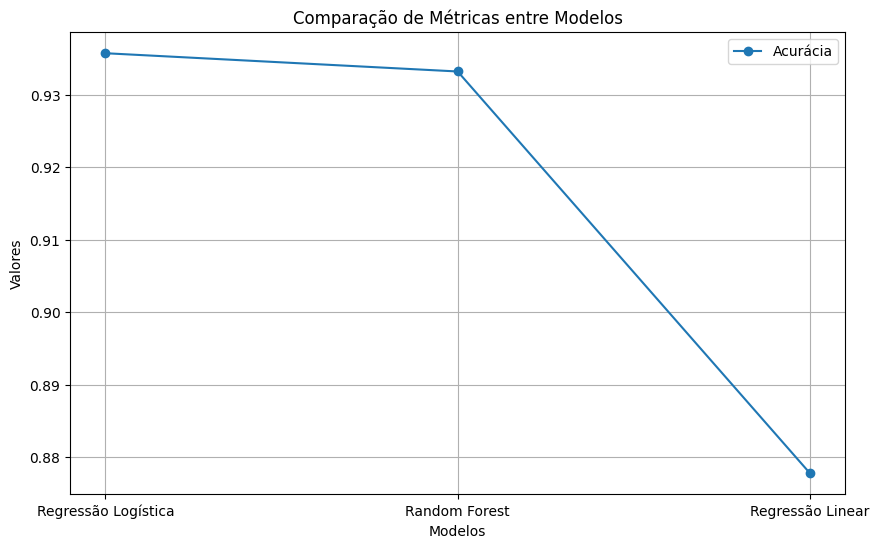

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Acurácia", "Precisão", "Recall", "F1-Score"]
values = {metric: [results[model].get(metric, None) for model in models.keys()] for metric in metrics}

plt.figure(figsize=(10, 6))
for metric, vals in values.items():
    if None not in vals:
        plt.plot(models.keys(), vals, marker='o', label=metric)

plt.xlabel("Modelos")
plt.ylabel("Valores")
plt.title("Comparação de Métricas entre Modelos")
plt.legend()
plt.grid(True)
plt.show()


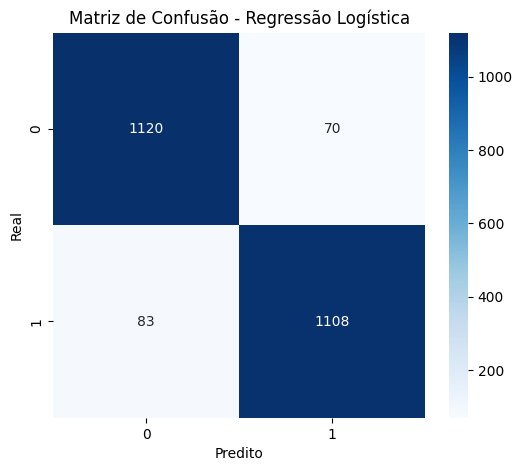

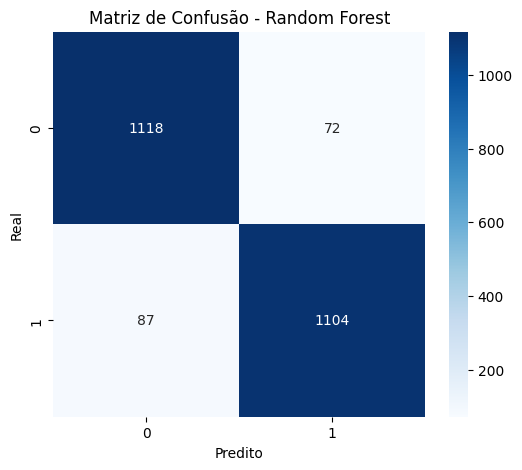

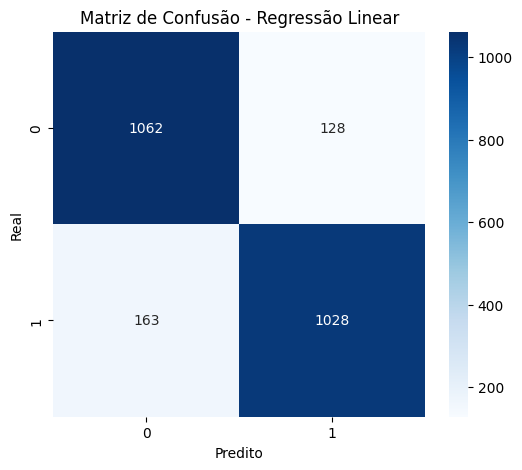

In [43]:
# Plotar matriz de confusão
for name, res in results.items():
    if "Matriz de Confusão" in res:
        plt.figure(figsize=(6,5))
        sns.heatmap(res["Matriz de Confusão"], annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusão - {name}")
        plt.show()

In [44]:
# Teste de Exemplos
exemplos = [
    "Polícia encontra provas contra político em escândalo de corrupção",
    "Novo estudo revela benefícios surpreendentes do café para a saúde",
    "NASA descobre planeta habitável próximo ao sistema solar",
    "Fake news sobre vacinas geram preocupação entre especialistas"
]

exemplos_processados = [limpar_texto(ex) for ex in exemplos]
exemplos_tfidf = vectorizer.transform(exemplos_processados)

print("\n Predições em Exemplos")
for name, model in models.items():
    predicoes = model.predict(exemplos_tfidf)
    if name == "Regressão Linear":
        predicoes = np.round(predicoes).astype(int)
        predicoes = np.clip(predicoes, 0, 1)
    print(f"\n{name}:")
    for texto, pred in zip(exemplos, predicoes):
        status = "FAKE NEWS" if pred == 1 else "VERDADEIRO"
        print(f" - {texto}: {status}")


 Predições em Exemplos

Regressão Logística:
 - Polícia encontra provas contra político em escândalo de corrupção: VERDADEIRO
 - Novo estudo revela benefícios surpreendentes do café para a saúde: FAKE NEWS
 - NASA descobre planeta habitável próximo ao sistema solar: VERDADEIRO
 - Fake news sobre vacinas geram preocupação entre especialistas: VERDADEIRO

Random Forest:
 - Polícia encontra provas contra político em escândalo de corrupção: VERDADEIRO
 - Novo estudo revela benefícios surpreendentes do café para a saúde: VERDADEIRO
 - NASA descobre planeta habitável próximo ao sistema solar: VERDADEIRO
 - Fake news sobre vacinas geram preocupação entre especialistas: VERDADEIRO

Regressão Linear:
 - Polícia encontra provas contra político em escândalo de corrupção: VERDADEIRO
 - Novo estudo revela benefícios surpreendentes do café para a saúde: FAKE NEWS
 - NASA descobre planeta habitável próximo ao sistema solar: FAKE NEWS
 - Fake news sobre vacinas geram preocupação entre especialistas: 